# 수치형변수 가공 데모

수치형변수는 가장 기본적인 변수 형태 중 하나입니다. 아래 3개의 변수 형태는 일반적으로 자주 관측되는 변수들입니다. 

- 수치형변수: 정수/실수 (집 값)
- 범주형변수: 범주 (성별)
- 이진변수: 참/거짓 (암 여부)

이번 장에서는 수치형변수를 가공하는 법에 대해 실습과 병행하며 알아보겠습니다. 

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from warnings import simplefilter

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
simplefilter('ignore')

## 학습데이터 로드

이번 실습에 사용할 데이터는 데이콘의 [영화 관객수 예측 모델 개발](https://dacon.io/competitions/open/235536/data/) 페이지에서 다운로드하여 `../data/movies/` 폴더에 저장을 해둡니다. 해당 데이터는 영화의 장르, 개봉일, 상영시간 등의 데이터로 영화 총 관객수 (`box_off_num`)를 예측하는 데이터입니다. 

In [4]:
data_dir = Path('../data/movies/')
trn_file = data_dir / 'movies_train.csv'
seed = 42

In [5]:
df = pd.read_csv(trn_file, index_col=0)
print(df.shape)
df.head()

(600, 11)


,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
title,,,,,,,,,,,
개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


데이터를 확인해보면 총 `time`, `dir_prev_bfnum`, `dir_prev_num`, `num_staff`, `num_actor`, 그리고 `box_off_num`까지 총 6개의 수치형변수가 존재함을 알 수 있습니다. 또한 `release_time` 데이터도 변환 과정을 통해 수치형변수로 가공할 수 있습니다. 해당 과정 또한 이번 실습에서 살펴보겠습니다. 

## EDA (Exploratory Data Analysis)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 개들의 전쟁 to 베를린
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     600 non-null    object 
 1   genre           600 non-null    object 
 2   release_time    600 non-null    object 
 3   time            600 non-null    int64  
 4   screening_rat   600 non-null    object 
 5   director        600 non-null    object 
 6   dir_prev_bfnum  270 non-null    float64
 7   dir_prev_num    600 non-null    int64  
 8   num_staff       600 non-null    int64  
 9   num_actor       600 non-null    int64  
 10  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 56.2+ KB


`info()`함수를 통해 각 열의 데이터 타입과 결측값 존재 유무를 확인할 수 있습니다. 데이터 타입으로 `object`, `int64`, `float64`이 현재 데이터에 존재하며 `object`는 문자열 데이터를 뜻합니다. 수치형 변수중 유일하게 `dir_prev_bfnum`만 `float64`인 것을 확인할 수 있습니다. 해당 열에는 결측값이 330개의 결측값이 존재하는데, 결측값이 `float64`형태로 인식되기 때문에 전체 열의 데이터 타입 또한 `float64`인 것을 확인할 수 있습니다.

In [7]:
df.fillna(0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 개들의 전쟁 to 베를린
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     600 non-null    object 
 1   genre           600 non-null    object 
 2   release_time    600 non-null    object 
 3   time            600 non-null    int64  
 4   screening_rat   600 non-null    object 
 5   director        600 non-null    object 
 6   dir_prev_bfnum  600 non-null    float64
 7   dir_prev_num    600 non-null    int64  
 8   num_staff       600 non-null    int64  
 9   num_actor       600 non-null    int64  
 10  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 56.2+ KB


결측값을 0으로 대체합니다. 

In [8]:
df.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,6.000000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,4.726993e+05,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.309474e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,0.000000e+00,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,0.000000e+00,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,3.761416e+05,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


수치형변수의 분포로부터 모든 수치형변수가 0 또는 양수의 값을 가짐을 알 수 있습니다.

In [9]:
target_col = 'box_off_num'
pred_col = 'pred'
num_cols = [x for x in df.columns if df[x].dtype in [np.int64, np.float64] and x != target_col]
print(num_cols)

['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']


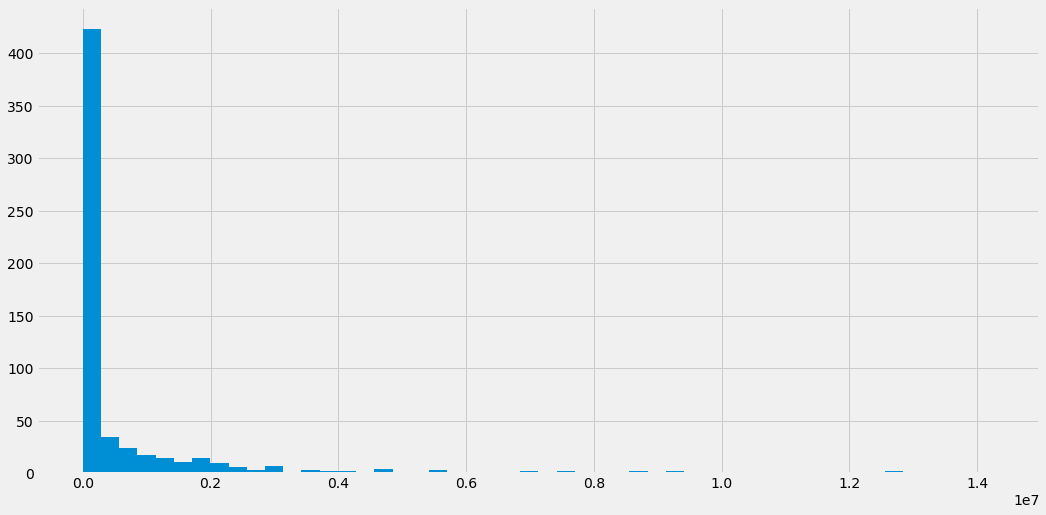

In [10]:
df.box_off_num.hist(bins=50)

예측 대상이 되는 타겟 변수인 `box_off_num`의 히스토그램을 확인해보면 0근처에 값이 집중적으로 분포함을 알 수 있습니다. 그래프 우측 하단에 `1e7`라는 숫자가 있는데 이것은 10^7을 뜻하며 10,000,000을 뜻합니다. 즉 x축에 1천만을 곱한 것이 원래 값이며 히스토그램을 통해 대부분 2백만 이하의 관객수를 달성한 것을 확인할 수 있습니다. 

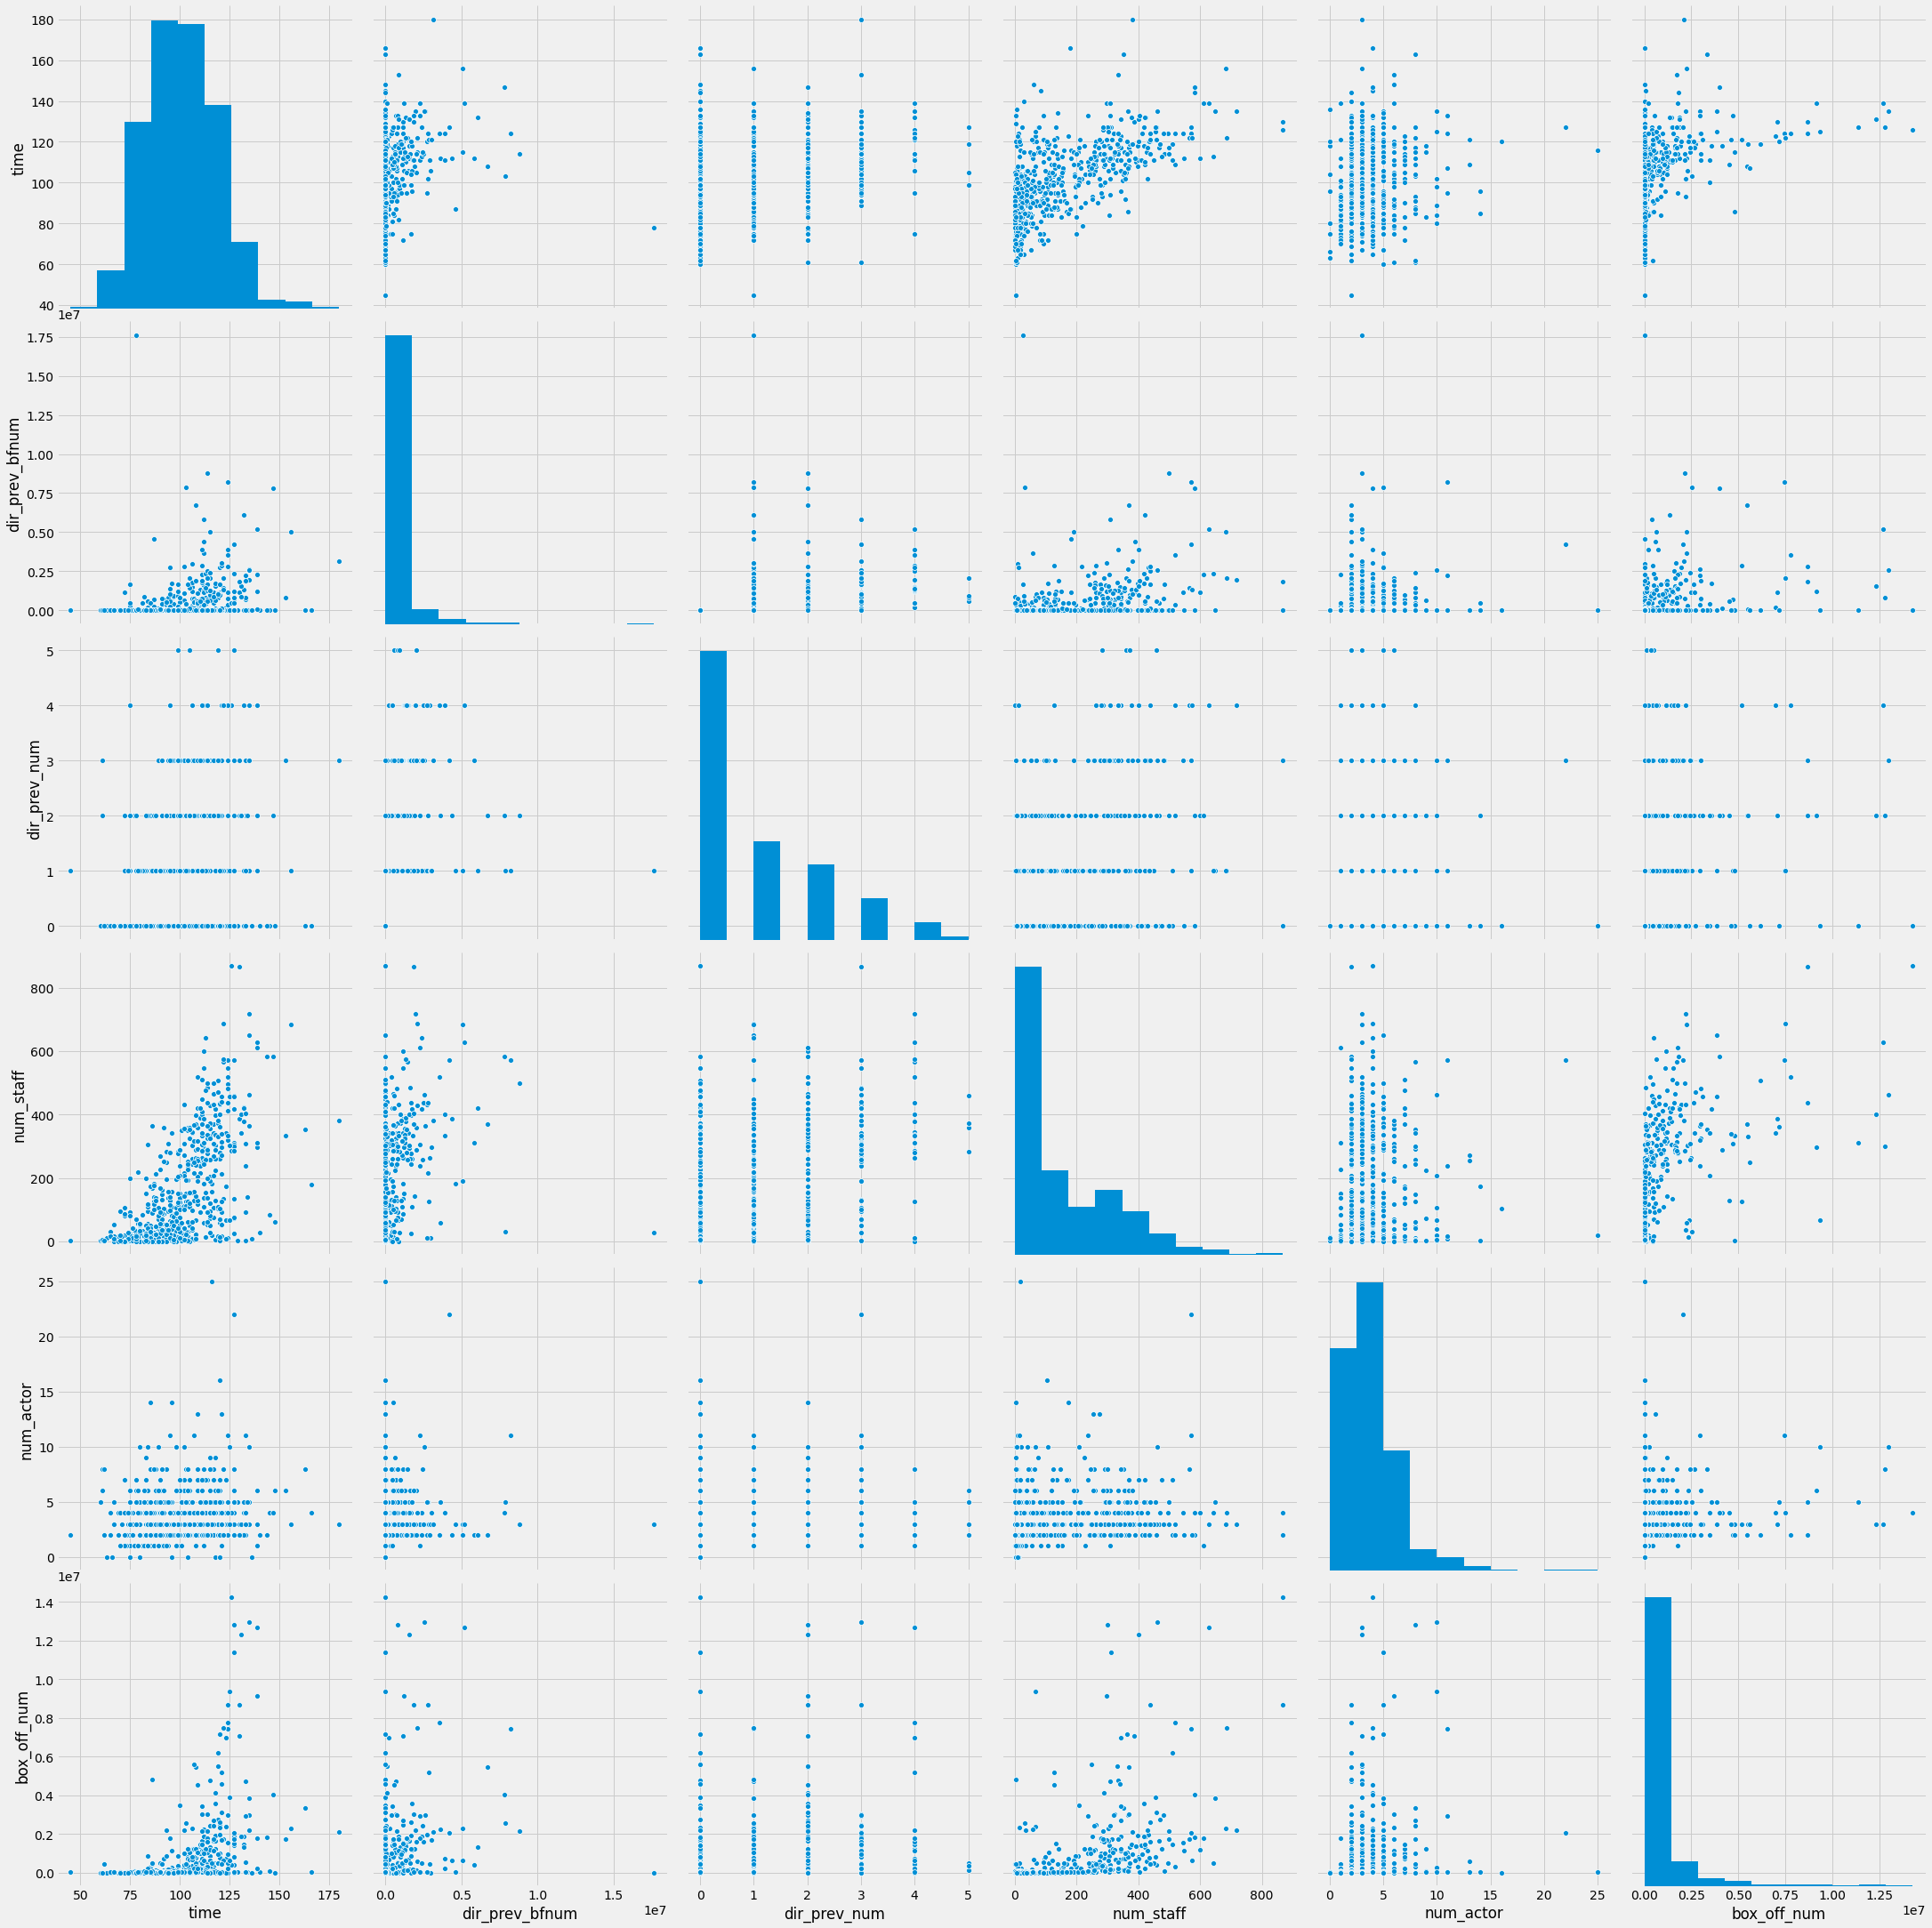

In [11]:
sns.pairplot(data=df, vars=num_cols + [target_col], size=5)

수치형변수 중 `time`은 정규분포에 가깝고 나머지는 멱함수 (power-law)분포에 가깝습니다.

```{note}
3장에서는 왼쪽에 쏠린 분포를 지수분포라고 안내했습니다. 멱함수 분포와 지수분포는 가시적으로 왼쪽에 쏠린 분포라는 점에서 비슷해 보이지만 수식이 다르며 그에 따라 각 분포별 특성도 다릅니다. 

https://math.stackexchange.com/questions/164436/difference-between-power-law-distribution-and-exponential-decay
```

In [12]:
df.corr().style.background_gradient()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.266065,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.266065,1.000000,0.396616,0.369657,0.042491,0.293791
dir_prev_num,0.306727,0.396616,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.369657,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.042491,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.293791,0.259674,0.544265,0.111179,1.000000


## 선형회귀 모델 학습

### RMSE/RMLSE 손실함수 정의

In [13]:
rmse = lambda y, p: np.sqrt(mean_squared_error(y, p))
rmlse = lambda y, p: np.sqrt(mean_squared_error(np.log1p(y), np.log1p(p)))

### 변수 가공없이 선형회귀 모델 학습

In [14]:
lr = LinearRegression()
lr.fit(df[num_cols], df[target_col])
df[pred_col] = lr.predict(df[num_cols])

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1500066.43


LinearRegression 모델을 초기화 한 후 `fit()`함수를 통해 학습을 합니다. 그리고 `predict()`을 통해 예측한 예측값을 `df[pred_col]`열에 저장합니다. RMSE를 산출해보면 1,500,066이 나온것을 알 수 있습니다. 

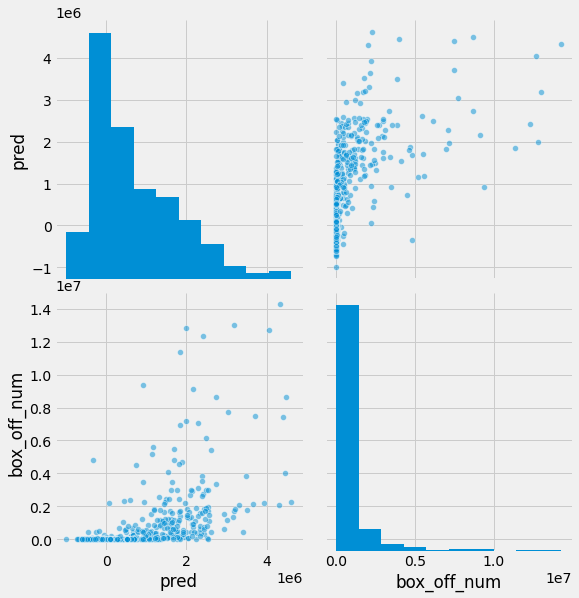

In [15]:
sns.pairplot(data=df, vars=[pred_col, target_col], size=4, plot_kws={'alpha': .5})

종속변수가 멱함수 분포를 지닐 때 선형회귀 모델을 학습하고 예측하면 예측값에 음수가 나올 수 있으며 수치가 낮은 값에 대한 예측에는 오차가 많이 발생합니다. 우측 상단에 있는 산점도를 통해 이를 확인할 수 있습니다. 이상적으로 예측된 경우 우상향하는 대각선을 중심으로 산점도가 형성되어야 합니다. 하지만 현재 그래프는 실제 `box_off_num`이 0주변의 값일 때 예측값은 2백만으로도 예측을 하는 경우가 이습니다. 

### 멱함수 분포 변수 `log1p` 변환

앞서 확인한 2가지 문제를 해결하기 위해 로그변환을 사용할 수 있습니다. 

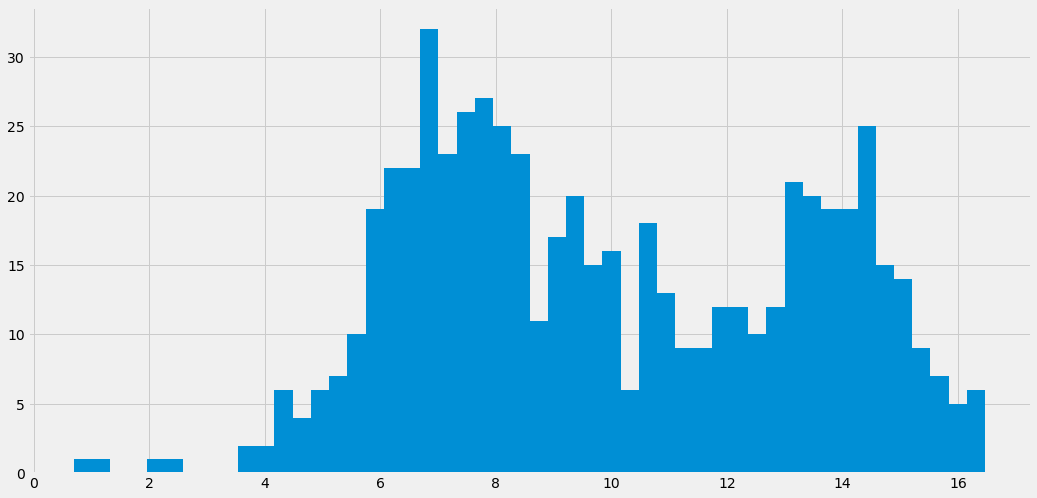

In [16]:
df.box_off_num.apply(np.log1p).hist(bins=50)

멱함수 분포의 수치형 변수는 `np.log1p()` 함수로 정규분포에 가깝게 변환할 수 있습니다. `np.log1p()`함수는 원본 값에 1을 더해서 로그변환을 해주는 함수입니다. 1을 더해주는 이유는 원본 값에 0이 있을 경우 로그 값이 음의 무한대의 값을 갖기 때문에 해당 경우를 처리해주기 위함입니다. 로그변환된 종속변수로 선형회귀 모델을 학습한 후 예측값을 산출하면, 해당 값은 로그변환이 적용된 상태이기 때문에 역변환을 통해 원본 스케일로 변환을 해주어야 합니다. 이 때 사용하는 함수는 `np.expm1()`입니다. 앞서 1을 더해준 후 로그변환을 했기 때문에 역변환 이후에 1을 빼주기 위해 `np.expm1()`을 사용합니다. 

In [17]:
lr = LinearRegression()
lr.fit(df[num_cols], np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(df[num_cols]))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	 17129211.69
RMLSE:	        2.12


로그변환한 종속변수로 모델을 학습하고 예측을 합니다. 그리고 예측값을 `np.expm1()`을 통해 역변환 한뒤 `df[pred_col]`에 저장합니다. RMSE와 RMSLE(Root Mean Squared Logarithmic Error)를 계산해보면 위와 같습니다. RMSE는 로그변환을 하지 않았을 때보다 10배 이상 나빠진 것을 확인할 수 있습니다. 로그변환을 하게 되면 적은 숫자들에 대해서는 잘 예측을 하지만 값이 큰 숫자에 대한 오차가 더 커져서 이러한 현상이 발생합니다. 

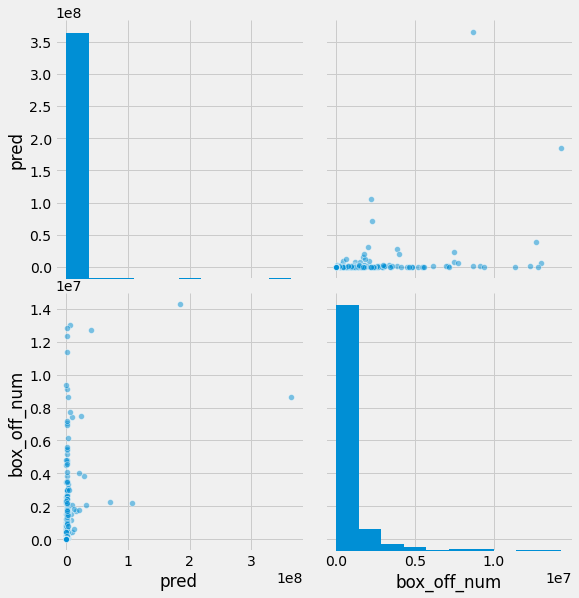

In [18]:
sns.pairplot(data=df, vars=[pred_col, target_col], size=4, plot_kws={'alpha': .5})

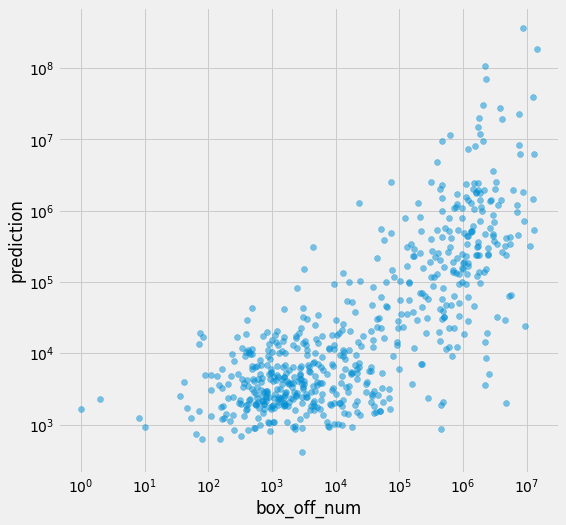

In [19]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')

In [20]:
df[num_cols].describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,600.000000,6.000000e+02,600.000000,600.000000,600.000000
mean,100.863333,4.726993e+05,0.876667,151.118333,3.706667
std,18.097528,1.309474e+06,1.183409,165.654671,2.446889
min,45.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,89.000000,0.000000e+00,0.000000,17.000000,2.000000
50%,100.000000,0.000000e+00,0.000000,82.500000,3.000000
75%,114.000000,3.761416e+05,2.000000,264.000000,4.000000
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000


In [21]:
df[['dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']] = df[['dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']].apply(np.log1p)
df[num_cols].describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,600.000000,600.000000,600.000000,600.000000,600.000000
mean,100.863333,5.305796,0.462197,4.026352,1.446130
std,18.097528,6.254561,0.555570,1.789517,0.446256
min,45.000000,0.000000,0.000000,0.000000,0.000000
25%,89.000000,0.000000,0.000000,2.890372,1.098612
50%,100.000000,0.000000,0.000000,4.424829,1.386294
75%,114.000000,12.837611,1.098612,5.579730,1.609438
max,180.000000,16.684279,1.791759,6.768493,3.258097


수치형 독립변수 중 멱변환 분포를 따르는 변수에도 `np.log1p()` 변환을 적용하였다.

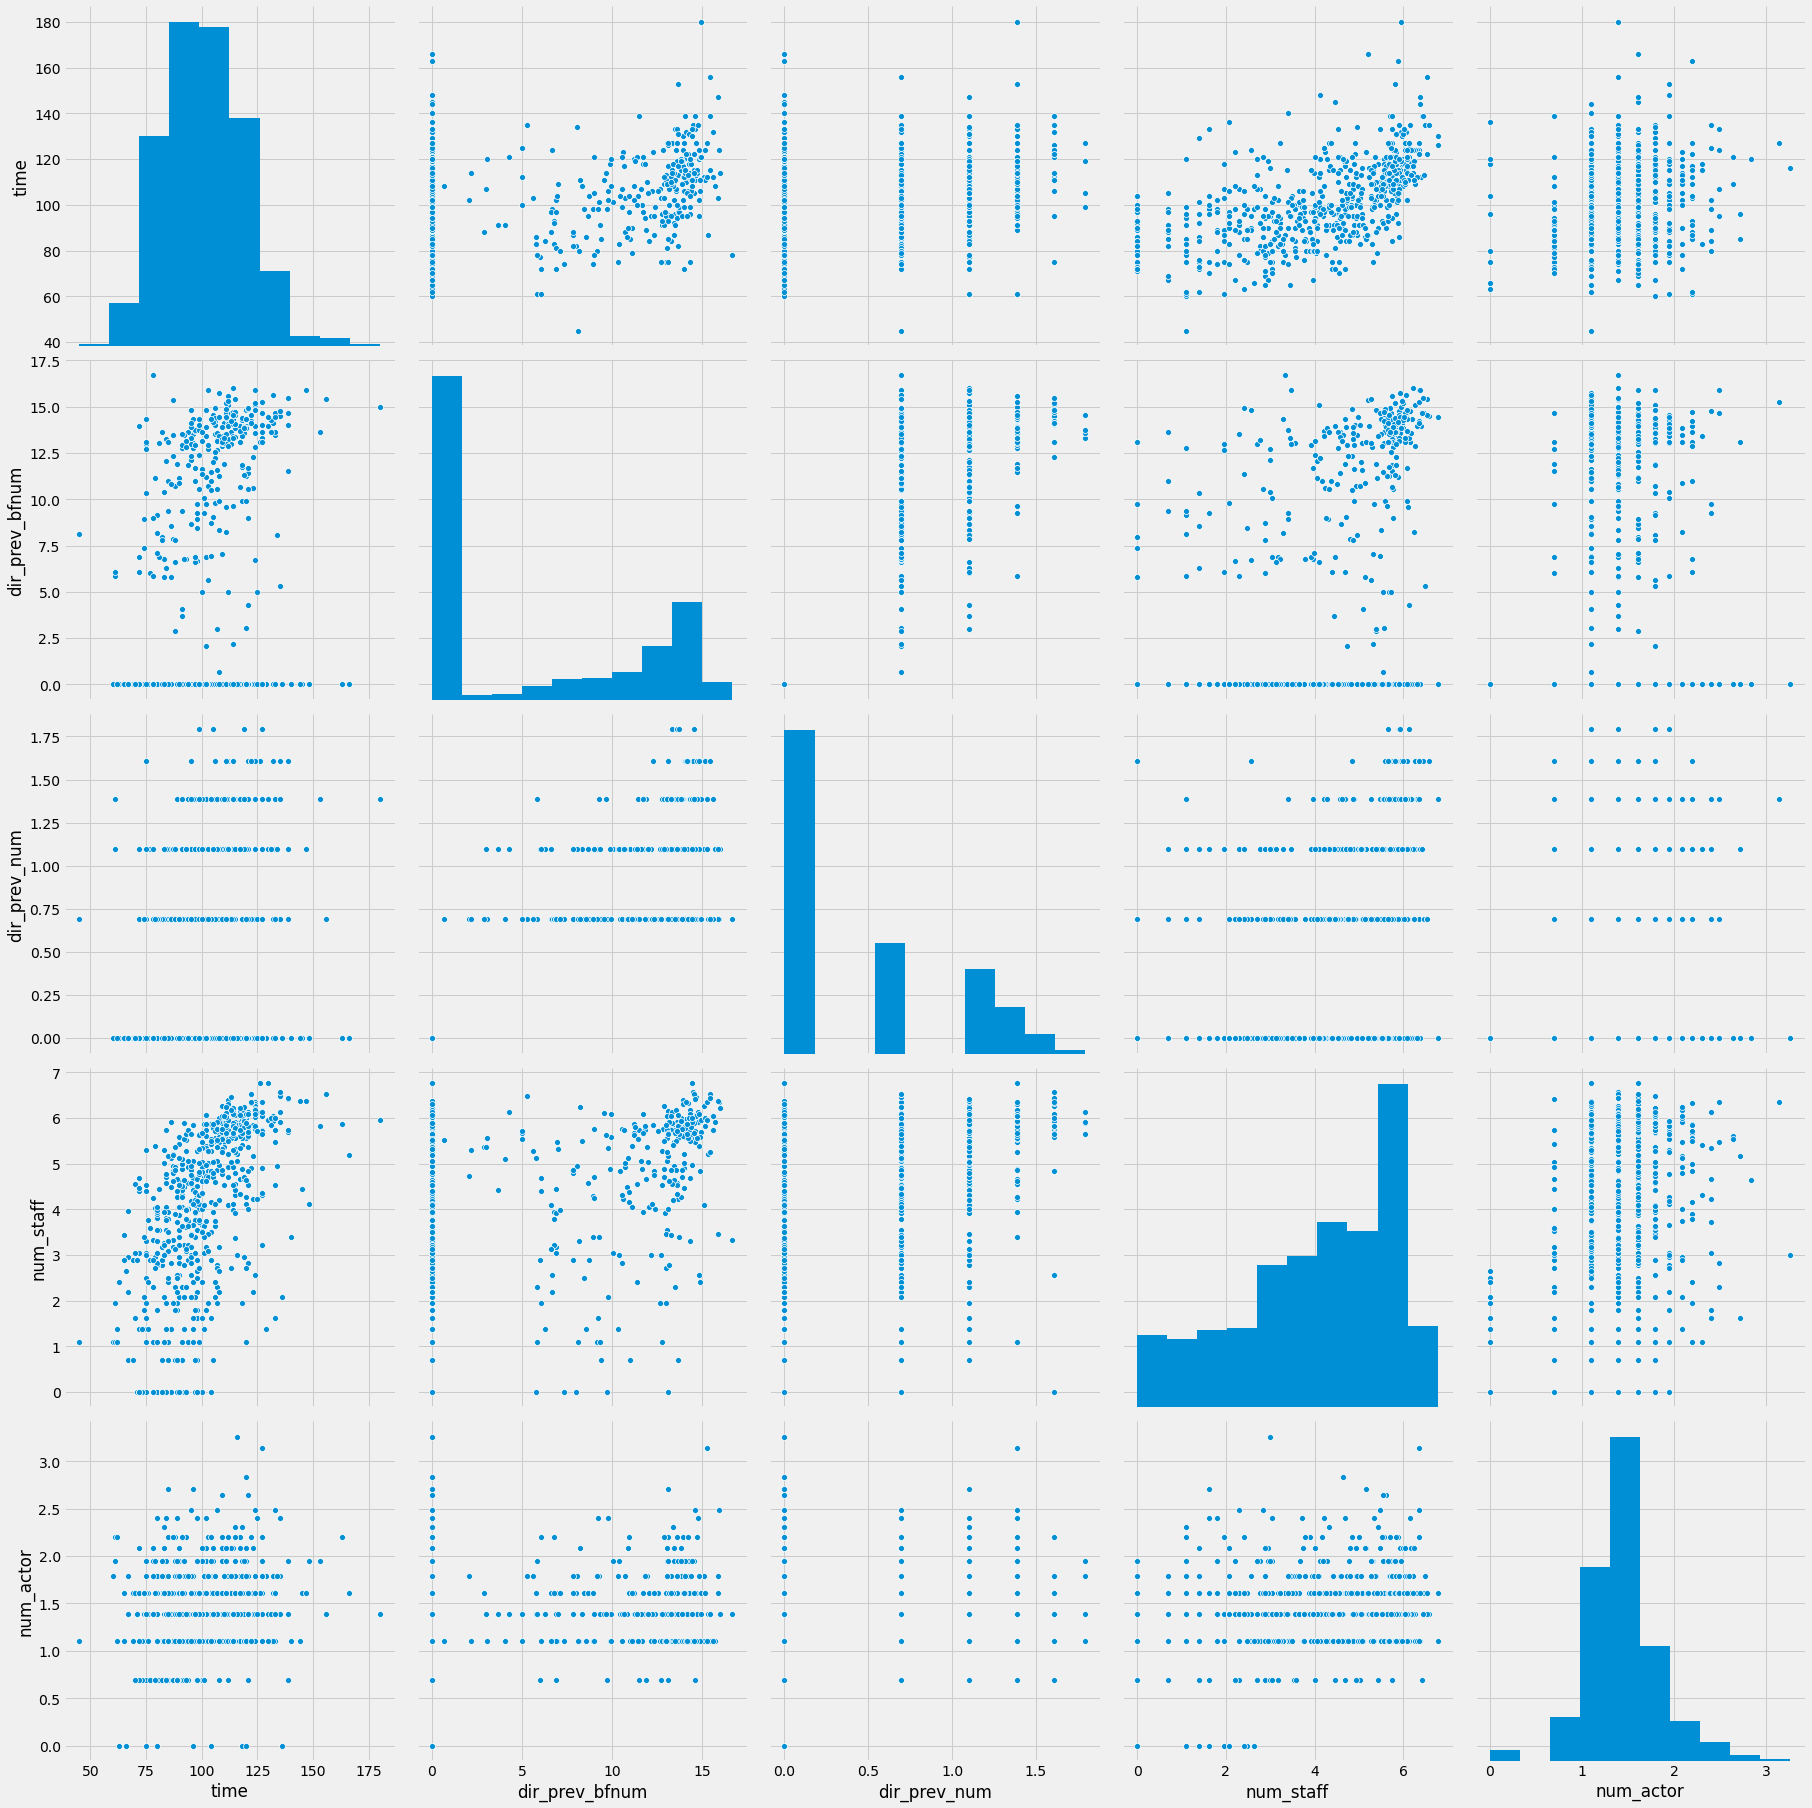

In [22]:
sns.pairplot(data=df, vars=num_cols, size=5)

In [23]:
lr = LinearRegression()
lr.fit(df[num_cols], np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(df[num_cols]))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1883568.88
RMLSE:	        2.32


RMLSE는 조금 나빠졌지만 RMSE는 크게 개선이 되었다.

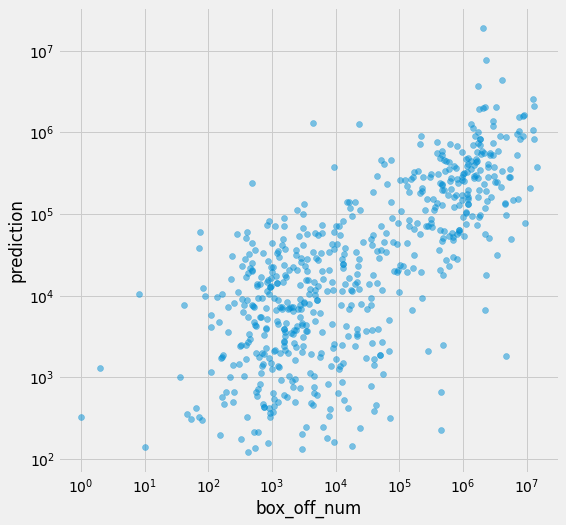

In [24]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')

In [25]:
df.head()

,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,pred
title,,,,,,,,,,,,
개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.000000,0.000000,4.521789,1.098612,23398,12093.438433
내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,13.965312,1.098612,5.961005,1.386294,7072501,963891.149247
은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,12.304905,1.609438,5.840642,1.609438,6959083,521738.259465
나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,10.081425,1.098612,3.044522,1.945910,217866,19533.298119
불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,0.693147,0.693147,5.529429,1.098612,483387,50007.266863


### 날짜/시간 변수 처리

In [26]:
df['release_time'] = pd.to_datetime(df['release_time'])
df['release_time'].describe()

count                     600
unique                    330
top       2015-08-13 00:00:00
freq                        6
first     2010-01-02 00:00:00
last      2015-12-31 00:00:00
Name: release_time, dtype: object

날짜/시간 변수를 처리하기 위해선 `pd.to_datetime()`함수로 문자열 값을 datetime 타입으로 변경해줘야 합니다. 그리고 나서 아래 코드와 같이 년/월을 추출할 수 있습니다. `describe()`함수로 분포를 확인해보면 가장 먼저 시작된 영화의 상영일은 2010년 1월 2일임을 알 수 있고 가장 최근에 상영된 영화는 2015년 12월 31일에 상영된 것을 알 수 있습니다. 

In [27]:
df['year'] = df['release_time'].dt.year
df['month'] = df['release_time'].dt.month
df.head()

,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,pred,year,month
title,,,,,,,,,,,,,,
개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.000000,0.000000,4.521789,1.098612,23398,12093.438433,2012,11
내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,13.965312,1.098612,5.961005,1.386294,7072501,963891.149247,2015,11
은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,12.304905,1.609438,5.840642,1.609438,6959083,521738.259465,2013,6
나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,10.081425,1.098612,3.044522,1.945910,217866,19533.298119,2012,7
불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,0.693147,0.693147,5.529429,1.098612,483387,50007.266863,2010,11


`dt.year`는 년도를 추출해주며 `dt.month`는 월을 추출합니다. 

In [28]:
num_cols += ['year', 'month']
print(num_cols)

['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor', 'year', 'month']


In [29]:
lr = LinearRegression()
lr.fit(df[num_cols], np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(df[num_cols]))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1893420.63
RMLSE:	        2.31


### 정규화/스케일링

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

알고리즘에 따라 수치형변숭 스케일링/정규분포화를 적용할 수 있습니다. 해당 방법은 선형회귀/결정트리 류의 알고리즘에는 도움이 되지는 않습니다. 해당 알고리즘은 스케일이 무관하게 학습을 하지만 신경망 네트워크 모델인 경우 스케일링이 중요하게 작용합니다. 

In [31]:
scaler = StandardScaler()
X = scaler.fit_transform(df[num_cols])

lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1893420.63
RMLSE:	        2.31


정규분포화는 `StandardScaler()`를 통해 적용가능합니다. 정규화를 해도 rmse와 rmsle에 변화는 없는것을 확인할 수 있습니다. 

In [32]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df[num_cols])

lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1893420.63
RMLSE:	        2.31


`MinMaxScaler()`는 최솟값과 최댓값을 각각 0과 1로 변환해줍니다. 마찬가지로 선형회귀모델인 경우 손실함수에 변화는 없습니다. 

### Binning

수치형변수에는 binning을 적용할 수 있습니다. binning을 통해 수치형변수를 범주형변수로 변환할 수 있습니다. 

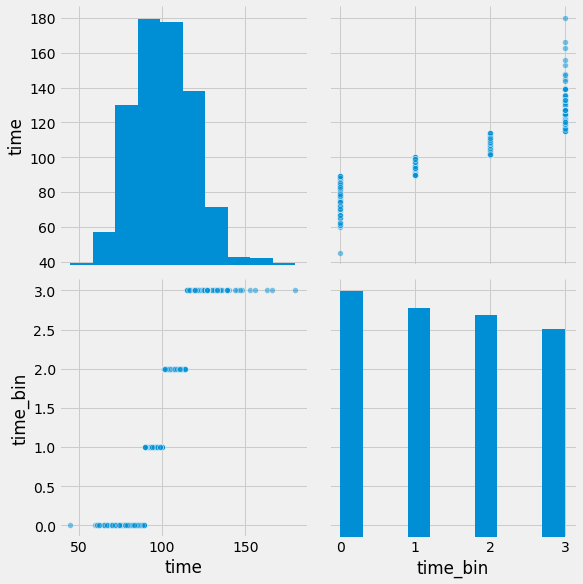

In [33]:
df['time_bin'] = pd.qcut(df['time'], 4, labels=False)
sns.pairplot(data=df, vars=['time', 'time_bin'], size=4, plot_kws={'alpha': .5})

`pd.qcut()`함수를 사용해 binning을 할 수 있습니다. 두번째 파라미터에 4를 입력함으로써 총 4개의 bin으로 그룹을 짓게 됩니다. 수치값을 정렬한 뒤 1/4지점에 있는 값끼리 묶어서 0, 1, 2, 3의 라벨을 부여합니다. 

In [34]:
df['time_bin'] = pd.qcut(df['time'], 4, labels=False)
df[['time', 'time_bin']].head(10)

,time,time_bin
title,,
개들의 전쟁,96,1
내부자들,130,3
은밀하게 위대하게,123,3
나는 공무원이다,101,2
불량남녀,108,2
강철대오 : 구국의 철가방,113,2
길위에서,104,2
회사원,96,1
"1789, 바스티유의 연인들",129,3


In [35]:
X = pd.concat([df[num_cols], pd.get_dummies(pd.qcut(df['time'], 4, labels=False))], axis=1)
X.shape

(600, 11)

In [36]:
lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1730191.35
RMLSE:	        2.25


In [37]:
X = pd.concat([df[[x for x in num_cols if x != 'month']], 
               pd.get_dummies(pd.qcut(df['time'], 4, labels=False)),
               pd.get_dummies(df['month'])], axis=1)
X.shape

(600, 22)

범주형 변수를 one hot encoding방식으로 변환해서 독립변수로 사용한 후 선형회귀 모델을 학습시켜 보겠습니다. 

In [38]:
lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1693164.29
RMLSE:	        2.22


RMSE와 RMSLE가 감소한 것을 확인할 수 있습니다. 

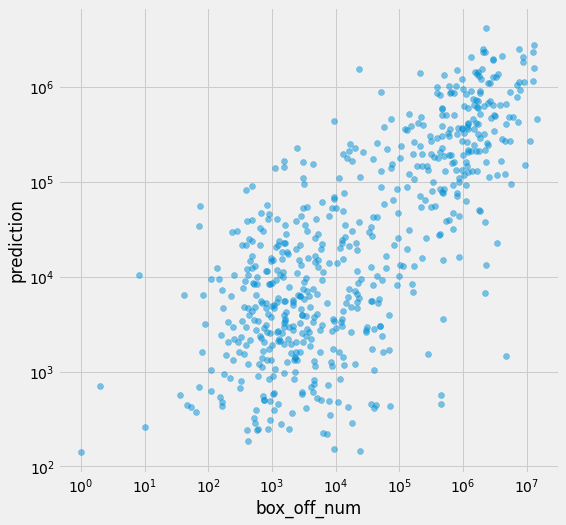

In [39]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')

### 2차 다항회귀 (Polynomial Regression)

다항회귀는 여러개의 독립변수가 존재할 때 독립변수끼리 조합을 실시해 추가 변수를 만들어 모델을 생성하는 방법입니다. 

In [40]:
from sklearn.preprocessing import PolynomialFeatures

In [41]:
poly = PolynomialFeatures(2)
X = poly.fit_transform(df[num_cols])
print(X.shape)

(600, 36)


`sklearn.preprocessing`모듈에서 `PolynomialFeatures`함수를 통해 다항회귀 변환을 실시할 수 이습니다. 위 예시는 2차 다항회귀 변환을 실시하는 예시입니다. 

In [42]:
lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  2925429.89
RMLSE:	        2.00


변형된 데이터로 모델을 학습시키고 예측해보면 rmsle는 감소했지만 rmse는 증가한 것을 볼 수 있습니다. 이처럼 다항회귀는 오버피팅/과적합의 위험이 존재하기 때문에 선별적으로 사용해야 합니다. 

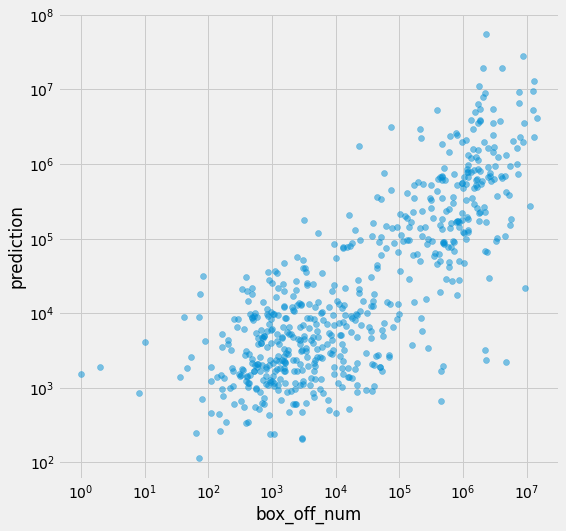

In [43]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')

## 참고자료

- [Feature Engineering by HJ van Veen](https://www.slideshare.net/HJvanVeen/feature-engineering-72376750)
    - 약 100페이지 정도가 되는 슬라이드며 어떤 경우에 특정 feature engineering 방법을 사용하는지 자세히 설명돼있습니다. 
- [scikit-learn의 Preprocessing 페이지](https://scikit-learn.org/stable/modules/preprocessing.html)
    - [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
    - [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler)
- Pandas
    - [to_datetime()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html)
    - [qcut()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html)
    - [get_dummies()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)
    - 이번 실습에 활용한 주요 함수들의 상세 설명페이지 입니다. 


